In [5]:
import cvxpy as cp
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [6]:
df_WS = pd.read_csv('/Users/lynnekiesling/Documents/projects/SLAC TESS//Ercot_LZ_SOUTH.csv',parse_dates=True,index_col=[0]) # For year 2016
df_WS.head()
print(df_WS.head())
df_WS = df_WS[~df_WS.index.duplicated(keep='last')]
# the ~ inverts the true/false, square bracket says "keep true"
#is this robust to more than one duplicate? yes
#change units, divide by 1000 to get to kWh
df_WS = df_WS/1000

                        DA     RT
2016-01-01 00:00:00  18.22  15.48
2016-01-01 00:05:00  18.22  15.48
2016-01-01 00:10:00  18.22  15.48
2016-01-01 00:15:00  18.22  15.33
2016-01-01 00:20:00  18.22  15.33


In [7]:
start = datetime.datetime( 2016, 7, 1, 0, 0)
end = datetime.datetime( 2016, 7, 7, 23, 59, 59) #note the previous was only going through the 6th
interval = 300 # interval of market operation in seconds
market_intervals = pd.date_range(start,end,freq = str(int(interval/60))+'min')
market_intervals #the first hour in 5 minute increments
index = len(market_intervals)
print(len(market_intervals))

2016


In [4]:
RT = df_WS['RT']
prices = df_WS.RT[market_intervals] #check this line, possibly prices = df_WS["RT", market_intervals] ??? brush up on data frames
#print(len(prices))
# prices = [15]*3*12+[40]*3*12
T = len(prices)
prices

2016-07-01 00:00:00    19.48
2016-07-01 00:05:00    19.48
2016-07-01 00:10:00    19.48
2016-07-01 00:15:00    19.92
2016-07-01 00:20:00    19.92
                       ...  
2016-07-07 00:40:00    18.14
2016-07-07 00:45:00    17.73
2016-07-07 00:50:00    17.73
2016-07-07 00:55:00    17.73
2016-07-07 01:00:00    18.17
Freq: 5T, Name: RT, Length: 1741, dtype: float64


2016-07-01 00:00:00    19.48
2016-07-01 00:05:00    19.48
2016-07-01 00:10:00    19.48
2016-07-01 00:15:00    19.92
2016-07-01 00:20:00    19.92
                       ...  
2016-07-07 00:40:00    18.14
2016-07-07 00:45:00    17.73
2016-07-07 00:50:00    17.73
2016-07-07 00:55:00    17.73
2016-07-07 01:00:00    18.17
Freq: 5T, Name: RT, Length: 1741, dtype: float64

In [5]:
# Initialize price parameters, T = number of market intervals
#prices = list(range(10,22))
T = len(prices)

#48 intervals of lower, and 48 intervals of higher price

# Initialize variables for cvxpy using cp.
SOC = cp.Variable((T+1,)) #check why T+1
x = cp.Variable((T,))
#profit = cp.Variable(1,)

# Initialize constraints
constraints = [SOC[0]==2.]
constraints += [SOC[T]==2.]

for t in range(T):
    #for each t, list of constraints that apply
    #constraints += [(-1<=x[t]), (x[t]<=1), 1<=SOC[t], SOC[t]<=5, SOC[t+1]==1*SOC[t]+x[t]/12.]
    constraints += [-1.<=x[t], x[t]<=1., 1.<=SOC[t], SOC[t]<=5., SOC[t+1]==0.99*SOC[t]+(x[t]/12)]

    # Objective function
obj = cp.sum(cp.multiply(prices,-x))
obj = cp.Maximize(obj)

In [6]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = (prob.solve())/12 #returns optimal value = prob.value
print(profits)

432.09850799397196


In [7]:
SOC_values = SOC.value
print(SOC_values)

[2.         1.91466667 1.82941867 ... 1.83708901 1.91858525 2.        ]


In [8]:
# Print output and solution characteristics

print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)
print(x)

# is it ok that the x array contains values other than -1, 0, 1?
#for the test, first half is positive because charging, and second half is discharging

status: optimal
optimal value 5185.182095927664
optimal var [-0.99999999 -0.99999998 -0.77736355 ...  1.          1.
  1.        ]
var1


In [9]:
x_values = x.value
print(x_values)

[-0.99999999 -0.99999998 -0.77736355 ...  1.          1.
  1.        ]


In [10]:
Pd = 0
Qd = x_values[0]
SOC = 2
df_store = pd.DataFrame(columns=['timestamp', 'RT', 'SOC_t', 'dispatch'])

In [11]:
len(x_values)

1741

In [12]:
(x_values)

array([-0.99999999, -0.99999998, -0.77736355, ...,  1.        ,
        1.        ,  1.        ])

In [13]:

first_element=[0]
SOC_values_final = np.delete(SOC_values, first_element)
SOC_values_final.size


1741

In [14]:

df_WS_restricted = df_WS.loc[market_intervals]

In [15]:
x.value

array([-0.99999999, -0.99999998, -0.77736355, ...,  1.        ,
        1.        ,  1.        ])

In [16]:
df_store['timestamp'] = df_WS_restricted.index
df_store['RT'] = df_store.timestamp.map(df_WS_restricted['RT'].to_dict())
# df_store['timestamp'] = range(len(prices))
# df_store['RT'] = prices
df_store['SOC_t'] = SOC_values_final
df_store['dispatch'] = x_values

# df_store.loc[df_store.duplicated(subset='timestamp')]

#df_store.drop_duplicates(subset='timestamp', keep='last', inplace=True)
#get df_store to be same size as x_values and SOC_values
#directly write this array to dataframe column
df_store

,timestamp,RT,SOC_t,dispatch
0,2016-07-01 00:00:00,19.48,1.914667,-1.000000
1,2016-07-01 00:05:00,19.48,1.829419,-1.000000
2,2016-07-01 00:10:00,19.48,1.762809,-0.777364
3,2016-07-01 00:15:00,19.92,1.677713,-1.000000
4,2016-07-01 00:20:00,19.92,1.592702,-1.000000
...,...,...,...,...
1736,2016-07-07 00:40:00,18.14,1.673852,1.000000
1737,2016-07-07 00:45:00,17.73,1.755511,1.000000
1738,2016-07-07 00:50:00,17.73,1.837089,1.000000
1739,2016-07-07 00:55:00,17.73,1.918585,1.000000


In [17]:
#find when SOC reaches max value
#do not use 
max_timestamp = df_store.loc[df_store.SOC_t >= 4.99, 'timestamp'].iloc[0]
min_timestamp = df_store.loc[df_store.SOC_t <= 1.01, 'timestamp'].iloc[0]
print(max_timestamp)
print(min_timestamp)
time_to_max = pd.date_range(min_timestamp,max_timestamp,freq=str(int(interval/60))+'min')
print(time_to_max)
delta = max_timestamp - min_timestamp
max_to_2max = pd.date_range(max_timestamp,max_timestamp + delta,freq=str(int(interval/60))+'min')
print(max_to_2max)
time_to_max_prices = df_store[df_store.timestamp.isin(time_to_max)]
max_to_2max_prices = df_store[df_store.timestamp.isin(max_to_2max)]
time_to_max_prices.RT.mean(), max_to_2max_prices.RT.mean()

2016-07-01 06:55:00
2016-07-01 00:55:00
DatetimeIndex(['2016-07-01 00:55:00', '2016-07-01 01:00:00',
               '2016-07-01 01:05:00', '2016-07-01 01:10:00',
               '2016-07-01 01:15:00', '2016-07-01 01:20:00',
               '2016-07-01 01:25:00', '2016-07-01 01:30:00',
               '2016-07-01 01:35:00', '2016-07-01 01:40:00',
               '2016-07-01 01:45:00', '2016-07-01 01:50:00',
               '2016-07-01 01:55:00', '2016-07-01 02:00:00',
               '2016-07-01 02:05:00', '2016-07-01 02:10:00',
               '2016-07-01 02:15:00', '2016-07-01 02:20:00',
               '2016-07-01 02:25:00', '2016-07-01 02:30:00',
               '2016-07-01 02:35:00', '2016-07-01 02:40:00',
               '2016-07-01 02:45:00', '2016-07-01 02:50:00',
               '2016-07-01 02:55:00', '2016-07-01 03:00:00',
               '2016-07-01 03:05:00', '2016-07-01 03:10:00',
               '2016-07-01 03:15:00', '2016-07-01 03:20:00',
               '2016-07-01 03:25:00', '2016-0

(17.313835616438354, 25.15958904109588)

In [18]:
def visualize_battery_dispatch(data):
    # Visualize battery dispatch over time as well as the market price
    fig = plt.figure(figsize=(9,3),dpi=150) 
    ax = fig.add_subplot(111)
    
    #plot1 = ax.plot(data.timestamp, data.RT, color='xkcd:sky blue', label='RT')
    plot1 = ax.step(data.timestamp, data.RT, where="post", color='xkcd:sky blue', label='RT')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/MWh)')
#    ax.set_xlim(xmin=data.iloc[0]['timestamp'], xmax=data.iloc[-1]['timestamp']+pd.Timedelta(days=1))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
#    ax.set_ylim(-1,5)

    ax2 = ax.twinx()
    #plot2 = ax2.plot(data.timestamp, data.SOC_t, color='orange', label='SOC')
    plot2 = ax2.step(data.timestamp, data.SOC_t, where="post", color='orange', label='SOC')
    ax2.set_ylabel('State of Charge')
    ax2.set_ylim(-4,10)
    
    
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    #plot3 = ax3.plot(data.timestamp, data.dispatch, color='red', label='load')
    plot3 = ax3.step(data.timestamp, data.dispatch, where="post", color='red', label='load')
    ax3.set_ylabel('Load Dispatched')
    ax3.set_ylim(-8,2)


    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

<ipython-input-18-cb9e6cfd5068>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


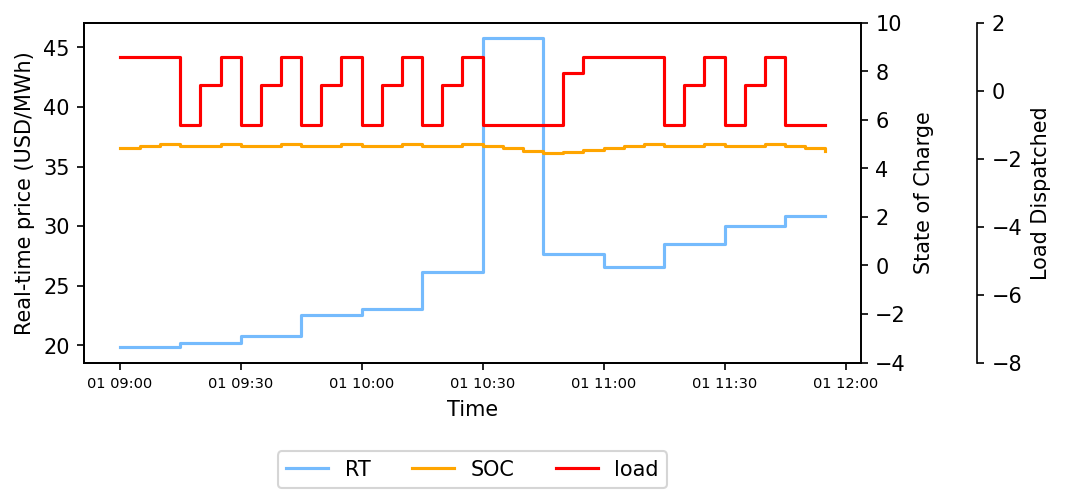

In [19]:
visualize_battery_dispatch(df_store.iloc[9*12:12*12])

In [20]:
# pd.daterange(.rand(), end_whichis_96intervalslater, freq=5)
xs = []
ys = []
for i in range(5000):
    begin_index = rd.sample(range(len(market_intervals)), 1)[0]
    sample_times = market_intervals[begin_index:begin_index+96]
    df_store_sample = df_store[df_store.timestamp.isin(sample_times)]
    
    ys.append(df_store_sample.iloc[:48].RT.mean() - df_store_sample.iloc[48:].RT.mean())
    xs.append(df_store_sample.iloc[:48].dispatch.mean() - df_store_sample.iloc[48:].dispatch.mean())

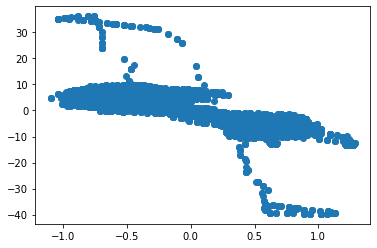

In [21]:
#doesn't dispatch when it is supposed to
plt.scatter(xs, ys)